# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [194]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


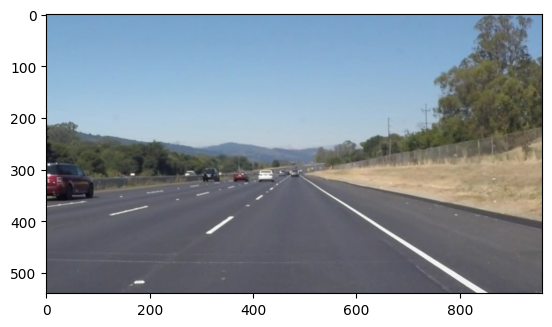

In [195]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [196]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    top = 320
    bottom = 550
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        #print(line)
        
        for x1,y1,x2,y2 in line:
            # Draw line segments in blue for error checking.
            #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1,y1,x2,y2)
            print(f'slope = {slope}\n')
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        # Slope = (y'- y) / (x'- x)  --> x' =  x + (y'- y) / slope
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        # Slope = (y'- y) / (x'- x)  --> x' =  x + (y'- y) / slope
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # Don't error when a line cannot be drawn
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

#def get_x(x,y,dy,slope):
    #return
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    # Make a RGB shape of the correct dimensions
    shape = (img.shape[0], img.shape[1], 3)
    line_img = np.zeros(shape, dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [197]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

slope = -0.7560975609756098

slope = -0.7281553398058253

slope = 0.6025641025641025

slope = 0.5737704918032787

slope = -0.7619047619047619

slope = 0.5666666666666667

slope = -0.7241379310344828

slope = 0.6170212765957447

slope = -0.7692307692307693

slope = 0.5238095238095238

slope = 0.5454545454545454

slope = -0.7692307692307693

slope = -0.7631578947368421

slope = 0.5263157894736842

slope = 0.6190476190476191



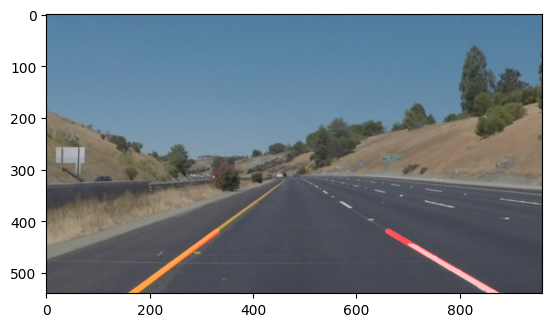

In [223]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Read in an image
#image = mpimg.imread('test_images\solidYellowLeft.jpg')
image = mpimg.imread('test_images\solidYellowCurve2.jpg')
#image = mpimg.imread('test_images\solidYellowCurve.jpg')

# Grayscale image
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

#plt.imshow(edges)
# Defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 350), (490, 350), (imshape[1],imshape[0])]], dtype=np.int32)
masked_img = region_of_interest(edges, vertices)
#plt.imshow(masked_img)
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 22     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 18 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
extend_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
line_image = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)

result = weighted_img(line_image, image)
plt.imshow(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [199]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [200]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    gaus = gaussian_blur(gray, 5)
    edges = canny(gaus, 60,180)    
    imshape = image.shape
    
    vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
    masked = region_of_interest(edges, vertices)
    
    rho = 2            #distance resolution in pixels of the Hough grid
    theta = np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 22#20     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 18 #25  #minimum number of pixels making up a line
    max_line_gap = 1 #10  #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
    result = weighted_img(line_image, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [201]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:  55%|█████▍    | 138/251 [13:33<00:01, 68.23it/s, now=None]

slope = 0.6290322580645161

slope = 0.6017699115044248

slope = -0.75

slope = -0.7

slope = 0.625

slope = 0.625

slope = 0.6049382716049383

slope = 0.5614035087719298

slope = -0.725

slope = 0.6071428571428571

slope = 0.5957446808510638

slope = 0.5925925925925926

slope = 0.5833333333333334

slope = 0.5517241379310345

slope = 0.5862068965517241

slope = -0.75

slope = 0.5652173913043478

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



slope = 0.6290322580645161

slope = 0.6017699115044248

slope = -0.75

slope = -0.7

slope = 0.625

slope = 0.625

slope = 0.6049382716049383

slope = 0.5614035087719298

slope = -0.725

slope = 0.6071428571428571

slope = 0.5957446808510638

slope = 0.5925925925925926

slope = 0.5833333333333334

slope = 0.5517241379310345

slope = 0.5862068965517241

slope = -0.75

slope = 0.5652173913043478

slope = 0.6031746031746031

slope = 0.6428571428571429

slope = -0.7631578947368421

slope = 0.6263736263736264

slope = -0.7

slope = 0.5802469135802469

slope = 0.6225165562913907

slope = 0.5454545454545454

slope = -0.7586206896551724

slope = 0.5714285714285714

slope = 0.5517241379310345

slope = -0.7037037037037037

slope = -0.7368421052631579

slope = 0.5909090909090909

slope = 0.5833333333333334

slope = 0.5555555555555556

slope = -0.65

slope = 0.55

slope = 0.5454545454545454

slope = 0.6

slope = -0.6842105263157895

slope = 0.5555555555555556

slope = 0.5555555555555556

slope = 0

slope = 0.6486486486486487

slope = 0.6190476190476191

slope = 0.625

slope = 0.6296296296296297

slope = 0.5789473684210527

slope = -0.7037037037037037

slope = -0.75

slope = 0.6153846153846154

slope = 0.68

slope = 0.6290322580645161

slope = -0.76

slope = 0.6086956521739131

slope = 0.6153846153846154

slope = 0.6111111111111112

slope = 0.6818181818181818

slope = 0.652542372881356

slope = 0.6257668711656442

slope = 0.6285714285714286

slope = -0.6875

slope = 0.6346153846153846

slope = -0.75

slope = 0.6333333333333333

slope = 0.6153846153846154

slope = 0.7

slope = 0.6111111111111112

slope = 0.5909090909090909

slope = 0.6233766233766234

slope = 0.6285714285714286

slope = 0.6516393442622951

slope = 0.6243654822335025

slope = 0.6379310344827587

slope = 0.6521739130434783

slope = -0.6944444444444444

slope = -0.7027027027027027

slope = 0.6111111111111112

slope = 0.631578947368421

slope = 0.6538461538461539

slope = 0.6585365853658537

slope = 0.631578947368421



slope = 0.6752767527675276

slope = 0.6464646464646465

slope = -0.6759259259259259

slope = -0.72

slope = 0.6413043478260869

slope = -0.7391304347826086

slope = -0.7241379310344828

slope = 0.6578947368421053

slope = 0.6923076923076923

slope = 0.6466165413533834

slope = 0.7037037037037037

slope = 0.6666666666666666

slope = 0.6736842105263158

slope = 0.6276595744680851

slope = 0.6277372262773723

slope = -0.673469387755102

slope = 0.6521739130434783

slope = -0.7166666666666667

slope = -0.673469387755102

slope = -0.7222222222222222

slope = 0.68

slope = -0.6666666666666666

slope = 0.7142857142857143

slope = 0.625

slope = -0.6538461538461539

slope = 0.6190476190476191

slope = 0.6097560975609756

slope = 0.6086956521739131

slope = 0.6304347826086957

slope = 0.6715328467153284

slope = -0.6796116504854369

slope = 0.6288659793814433

slope = 0.6065573770491803

slope = -0.717948717948718

slope = 0.6764705882352942

slope = -0.7368421052631579

slope = -0.722222222222

slope = 0.6743119266055045

slope = 0.7046979865771812

slope = -0.6444444444444445

slope = 0.675

slope = 0.6521739130434783

slope = -0.6666666666666666

slope = 0.6521739130434783

slope = 0.6666666666666666

slope = 0.6923076923076923

slope = 0.7142857142857143

slope = 0.68

slope = 0.65

slope = 0.6578947368421053

slope = 0.6833333333333333

slope = 0.6557377049180327

slope = 0.7317073170731707

slope = 0.7272727272727273

slope = -0.6538461538461539

slope = 0.7435897435897436

slope = -0.6923076923076923

slope = 0.6923076923076923

slope = 0.6190476190476191

slope = 0.6190476190476191

slope = 0.7142857142857143

slope = 0.6111111111111112

slope = 0.75

slope = 0.7272727272727273

slope = -0.64

slope = 0.7142857142857143

slope = 0.65

slope = 0.7037037037037037

slope = 0.6694915254237288

slope = 0.7040816326530612

slope = -0.7105263157894737

slope = 0.711864406779661

slope = 0.6666666666666666

slope = 0.72

slope = -0.6511627906976745

slope = 0.6153846153846154


slope = 0.6176470588235294

slope = 0.6509433962264151

slope = 0.6226993865030674

slope = 0.66

slope = -0.6666666666666666

slope = -0.696969696969697

slope = 0.6129032258064516

slope = 0.6111111111111112

slope = -0.6666666666666666

slope = 0.6190476190476191

slope = 0.6111111111111112

slope = 0.6296296296296297

slope = 0.6521739130434783

slope = 0.6216216216216216

slope = 0.6041666666666666

slope = 0.6509433962264151

slope = 0.6060606060606061

slope = -0.6666666666666666

slope = 0.6290322580645161

slope = -0.76

slope = 0.5652173913043478

slope = 0.5862068965517241

slope = 0.6190476190476191

slope = 0.5925925925925926

slope = 0.6

slope = 0.6333333333333333

slope = 0.5909090909090909

slope = 0.6176470588235294

slope = 0.6497695852534562

slope = 0.6056338028169014

slope = 0.6470588235294118

slope = 0.603448275862069

slope = 0.64

slope = -0.6551724137931034

slope = -0.717391304347826

slope = -0.6666666666666666

slope = 0.6666666666666666

slope = 0.578947

slope = 0.6043956043956044

slope = 0.5789473684210527

slope = 0.5806451612903226

slope = 0.6056338028169014

slope = 0.5555555555555556

slope = -0.7857142857142857

slope = 0.5555555555555556

slope = 0.5428571428571428

slope = -0.696969696969697

slope = 0.5522388059701493

slope = 0.5733333333333334

slope = 0.5454545454545454

slope = 0.5789473684210527

slope = 0.5625

slope = 0.5

slope = 0.5333333333333333

slope = 0.6

slope = 0.5909090909090909

slope = 0.5752212389380531

slope = 0.6035502958579881

slope = 0.5614035087719298

slope = 0.5609756097560976

slope = 0.5862068965517241

slope = -0.7741935483870968

slope = 0.6052631578947368

slope = 0.6

slope = -0.8095238095238095

slope = 0.5416666666666666

slope = 0.5849056603773585

slope = 0.5641025641025641

slope = 0.5769230769230769

slope = 0.5555555555555556

slope = 0.5333333333333333

slope = 0.55

slope = 0.5517241379310345

slope = 0.5454545454545454

slope = 0.55

slope = 0.5357142857142857

slope = 0.54166666

slope = 0.5934959349593496

slope = 0.6142857142857143

slope = 0.5728155339805825

slope = 0.6119402985074627

slope = -0.75

slope = 0.5833333333333334

slope = -0.7692307692307693

slope = 0.5757575757575758

slope = 0.5555555555555556

slope = 0.577639751552795

slope = 0.6140350877192983

slope = 0.631578947368421

slope = 0.6111111111111112

slope = 0.6

slope = 0.6

slope = 0.6190476190476191

slope = 0.65

slope = 0.5956284153005464

slope = 0.5763546798029556

slope = 0.5263157894736842

slope = 0.6101694915254238

slope = -0.75

slope = 0.5789473684210527

slope = -0.84

slope = 0.55

slope = 0.5555555555555556

slope = 0.5849056603773585

slope = -0.7222222222222222

slope = 0.575

slope = 0.47619047619047616

slope = 0.5925925925925926

slope = 0.6052631578947368

slope = 0.6190476190476191

slope = 0.5954198473282443

slope = 0.5714285714285714

slope = 0.5700934579439252

slope = 0.5765765765765766

slope = -0.8333333333333334

slope = 0.5873015873015873

slope = 0.611111

t:  55%|█████▍    | 138/251 [13:34<00:01, 68.23it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 1.56 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [202]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [203]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:  55%|█████▍    | 138/251 [13:35<00:01, 68.23it/s, now=None]

slope = -0.6028368794326241

slope = -0.6237623762376238

slope = 0.6590909090909091

slope = -0.628099173553719

slope = 0.7

slope = -0.6027397260273972

slope = 0.64

slope = -0.631578947368421

slope = 0.64

slope = -0.6153846153846154

slope = -0.8095238095238095

slope = -0.6

slope = -0.6086956521739131

slope = -0.6153846153846154

slope = -0.5909090909090909

slope = 0.5555555555555556

slope = 0.64

slope = -0.5909090909090909

slope = -0.5909090909090909

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



slope = -0.6028368794326241

slope = -0.6237623762376238

slope = 0.6590909090909091

slope = -0.628099173553719

slope = 0.7

slope = -0.6027397260273972

slope = 0.64

slope = -0.631578947368421

slope = 0.64

slope = -0.6153846153846154

slope = -0.8095238095238095

slope = -0.6

slope = -0.6086956521739131

slope = -0.6153846153846154

slope = -0.5909090909090909

slope = 0.5555555555555556

slope = 0.64

slope = -0.5909090909090909

slope = -0.5909090909090909

slope = -0.6190476190476191

slope = -0.6446280991735537

slope = -0.5964912280701754

slope = 0.6436781609195402

slope = -0.6144578313253012

slope = 0.7

slope = -0.6571428571428571

slope = -0.6666666666666666

slope = -0.5675675675675675

slope = -0.6585365853658537

slope = -0.7142857142857143

slope = 0.6666666666666666

slope = 0.6333333333333333

slope = -0.7

slope = -0.6842105263157895

slope = 0.717948717948718

slope = -0.7241379310344828

slope = -0.76

slope = -0.6086956521739131

slope = -0.6052631578947368


t:   4%|▍         | 29/681 [00:00<00:04, 143.21it/s, now=None]

slope = -0.6755555555555556

slope = -0.75

slope = -0.717948717948718

slope = -0.7073170731707317

slope = 0.625

slope = 0.6

slope = -0.7540983606557377

slope = -0.6666666666666666

slope = -0.6666666666666666

slope = 0.6190476190476191

slope = 0.5833333333333334

slope = -0.64

slope = 0.6296296296296297

slope = -0.6956521739130435

slope = 0.65

slope = 0.6363636363636364

slope = -1.0

slope = -0.6774193548387096

slope = 0.6111111111111112

slope = 0.6206896551724138

slope = -0.6778523489932886

slope = -0.75

slope = -0.7

slope = -0.75

slope = -0.7727272727272727

slope = -0.7857142857142857

slope = 0.6538461538461539

slope = -0.8181818181818182

slope = 0.5714285714285714

slope = -0.64

slope = -0.6190476190476191

slope = 0.5789473684210527

slope = -0.6923076923076923

slope = 0.5789473684210527

slope = -0.6551724137931034

slope = -0.6111111111111112

slope = 0.5652173913043478

slope = -0.75

slope = -0.7

slope = -0.6923076923076923

slope = -0.696969696969697

slope = -0.7032967032967034

slope = -0.735632183908046

slope = -0.7230769230769231

slope = -0.717391304347826

slope = -0.717948717948718

slope = 0.625

slope = 0.5833333333333334

slope = -0.7777777777777778

slope = -0.6842105263157895

slope = -0.7419354838709677

slope = -0.631578947368421

slope = -0.6842105263157895

slope = -0.6521739130434783

slope = -0.717391304347826

slope = 0.64

slope = -0.6956521739130435

slope = -0.65

slope = -0.6923076923076923

slope = -0.7018348623853211

slope = -0.7304964539007093

slope = 0.6190476190476191

slope = 0.6

slope = -0.7931034482758621

slope = -0.71875

slope = -0.7297297297297297

slope = -0.717391304347826

slope = -0.7083333333333334

slope = 0.5833333333333334

slope = -0.7

slope = -0.6964285714285714

slope = -0.7290836653386454

slope = -0.6862745098039216

slope = 0.589041095890411

slope = 0.6379310344827587

slope = -0.7142857142857143

slope = -0.7222222222222222

slope = -0.75

slope = 0.6842105263157895

slope = -0

t:  14%|█▎        | 93/681 [00:00<00:03, 147.14it/s, now=None]


slope = -0.6745562130177515

slope = -0.7222222222222222

slope = -0.7033492822966507

slope = 0.5833333333333334

slope = 0.6451612903225806

slope = 0.6086956521739131

slope = 0.6818181818181818

slope = -0.6956521739130435

slope = -0.7241379310344828

slope = -0.7017543859649122

slope = -0.6363636363636364

slope = -0.7857142857142857

slope = -0.6995073891625616

slope = -0.6666666666666666

slope = -0.6748466257668712

slope = -0.6764705882352942

slope = 0.6538461538461539

slope = 0.6071428571428571

slope = 0.625

slope = -0.7916666666666666

slope = -0.6551724137931034

slope = -0.6785714285714286

slope = -0.7049180327868853

slope = -0.68

slope = -0.7166666666666667

slope = -0.6774193548387096

slope = -0.6785714285714286

slope = 0.6086956521739131

slope = 0.6666666666666666

slope = -0.6923076923076923

slope = -0.6744186046511628

slope = -0.6875

slope = 0.6071428571428571

slope = -0.72

slope = -0.6818181818181818

slope = -0.6788321167883211

slope = -0.70786516

t:  19%|█▊        | 127/681 [00:00<00:03, 156.70it/s, now=None]

slope = -0.6781609195402298

slope = -0.7252747252747253

slope = -0.6888888888888889

slope = 0.6428571428571429

slope = 0.5961538461538461

slope = -0.6804123711340206

slope = 0.6086956521739131

slope = -0.72

slope = -0.6428571428571429

slope = -0.78125

slope = 0.5789473684210527

slope = -0.6363636363636364

slope = -0.7727272727272727

slope = -0.7142857142857143

slope = -0.6764705882352942

slope = 0.648854961832061

slope = -0.7301587301587301

slope = -0.7012987012987013

slope = -0.7586206896551724

slope = 0.6

slope = 0.59375

slope = -0.711864406779661

slope = 0.5957446808510638

slope = 0.6774193548387096

slope = -0.6666666666666666

slope = 0.6111111111111112

slope = 0.6666666666666666

slope = -0.6666666666666666

slope = 0.6538461538461539

slope = -0.6818181818181818

slope = -0.7575757575757576

slope = -0.6666666666666666

slope = -0.6956521739130435

slope = -0.6666666666666666

slope = -0.6470588235294118

slope = 0.6571428571428571

slope = -0.66666666666

slope = -0.6777777777777778

slope = -0.7142857142857143

slope = -0.7078651685393258

slope = -0.6595744680851063

slope = 0.5789473684210527

slope = -0.6923076923076923

slope = 0.5909090909090909

slope = -0.8148148148148148

slope = -0.68

slope = -0.75

slope = 0.5172413793103449

slope = 0.5909090909090909

slope = -0.6521739130434783

slope = -0.3333333333333333

slope = -0.7058823529411765

slope = -0.6818181818181818

slope = -0.6986301369863014

slope = -0.7232142857142857

slope = -0.7333333333333333

slope = -0.6956521739130435

slope = 0.5416666666666666

slope = 0.6037735849056604

slope = -0.7

slope = -0.782608695652174

slope = -0.71875

slope = 0.5714285714285714

slope = 0.5714285714285714

slope = -0.7619047619047619

slope = -0.7777777777777778

slope = -0.6956521739130435

slope = -0.7241379310344828

slope = -0.7368421052631579

slope = -0.7272727272727273

slope = -0.7391304347826086

slope = -0.65

slope = -0.7283950617283951

slope = -0.6986301369863014

slop

slope = -0.7567567567567568

slope = -0.8070175438596491

slope = -0.7903225806451613

slope = -0.78125

slope = -0.7777777777777778

slope = 0.5357142857142857

slope = 0.5652173913043478

slope = -0.8076923076923077

slope = -0.875

slope = -0.84

slope = 0.5714285714285714

slope = -0.7550200803212851

slope = -0.8095238095238095

slope = -0.8148148148148148

slope = -0.7560975609756098

slope = 0.5185185185185185

slope = 0.59375

slope = -0.7727272727272727

slope = -0.85

slope = -0.782608695652174

slope = -0.7857142857142857

slope = -0.7619047619047619

slope = 0.5714285714285714

slope = -0.7333333333333333

slope = -0.7241379310344828

slope = -0.8421052631578947

slope = -0.8333333333333334

slope = -0.8095238095238095

slope = -0.8076923076923077

slope = -0.8947368421052632

slope = -0.725

slope = 0.5365853658536586

slope = -0.85

slope = 0.5757575757575758

slope = -0.8333333333333334

slope = 0.5757575757575758

slope = -0.7

slope = -0.6842105263157895

slope = -0.73

t:  34%|███▍      | 230/681 [00:01<00:02, 164.75it/s, now=None]

slope = -0.7014925373134329

slope = -0.7567567567567568

slope = -0.7307692307692307

slope = -0.7037037037037037

slope = 0.5789473684210527

slope = 0.6166666666666667

slope = 0.5789473684210527

slope = -0.75

slope = 0.5714285714285714

slope = 0.6

slope = -0.7142857142857143

slope = -0.7307692307692307

slope = 0.5238095238095238

slope = -0.7916666666666666

slope = -0.7575757575757576

slope = 0.625

slope = -0.7040816326530612

slope = -0.7317073170731707

slope = -0.7777777777777778

slope = -0.7241379310344828

slope = -0.8125

slope = -0.717948717948718

slope = 0.6296296296296297

slope = 0.5862068965517241

slope = 0.5652173913043478

slope = -0.6956521739130435

slope = -0.85

slope = 0.45

slope = -0.6956521739130435

slope = -0.6975308641975309

slope = -0.75

slope = -0.75

slope = -0.75

slope = -0.78125

slope = -0.775

slope = 0.6333333333333333

slope = -0.7222222222222222

slope = -0.7

slope = -0.8888888888888888

slope = -0.7727272727272727

slope = -0.76923

slope = -0.7083333333333334

slope = -0.7692307692307693

slope = -0.7310924369747899

slope = -0.7222222222222222

slope = -0.6666666666666666

slope = 0.625

slope = 0.5833333333333334

slope = -0.7142857142857143

slope = -0.6923076923076923

slope = -0.6666666666666666

slope = -0.75

slope = 0.5161290322580645

slope = -0.7222222222222222

slope = -0.6363636363636364

slope = 0.6363636363636364

slope = -0.7391304347826086

slope = -0.6666666666666666

slope = -0.6764705882352942

slope = -0.6956521739130435

slope = -0.7297297297297297

slope = -0.6989247311827957

slope = -0.75

slope = 0.6

slope = -0.75

slope = 0.6216216216216216

slope = 0.5777777777777777

slope = -0.78125

slope = 0.6428571428571429

slope = -0.8

slope = -0.7142857142857143

slope = 0.5

slope = 0.5555555555555556

slope = -0.75

slope = -0.8

slope = 0.6470588235294118

slope = -0.6666666666666666

slope = 0.5652173913043478

slope = 0.47619047619047616

slope = 0.5737704918032787

slope = 0.619047619047

slope = -0.7012987012987013

slope = -0.7518248175182481

slope = 0.6086956521739131

slope = -0.7272727272727273

slope = 0.6326530612244898

slope = -0.75

slope = -0.7272727272727273

slope = -0.6956521739130435

slope = 0.5652173913043478

slope = -0.9523809523809523

slope = 0.5769230769230769

slope = -0.7083333333333334

slope = 0.5416666666666666

slope = -0.7727272727272727

slope = -0.71875

slope = -0.7666666666666667

slope = -0.7777777777777778

slope = -0.7009803921568627

slope = -0.7341772151898734

slope = 0.5849056603773585

slope = -0.8076923076923077

slope = 0.6153846153846154

slope = -0.84375

slope = 0.625

slope = -0.625

slope = -0.7631578947368421

slope = -0.7209302325581395

slope = -0.7037037037037037

slope = -0.6842105263157895

slope = -0.6956521739130435

slope = 0.6363636363636364

slope = -0.6842105263157895

slope = -0.7142857142857143

slope = -0.7010309278350515

slope = -0.7457627118644068

slope = -0.7931034482758621

slope = -0.74

slope = 0.61

slope = -0.7030567685589519

slope = -0.6875

slope = -0.6526315789473685

slope = 0.5774647887323944

slope = -0.7058823529411765

slope = 0.6142857142857143

slope = 0.56

slope = -0.7142857142857143

slope = -0.6666666666666666

slope = -0.71875

slope = 0.5833333333333334

slope = -0.6666666666666666

slope = -0.6333333333333333

slope = -0.6333333333333333

slope = -0.65

slope = -0.6190476190476191

slope = -0.65625

slope = -0.7

slope = -0.675

slope = 0.5822784810126582

slope = -0.6764705882352942

slope = 0.625

slope = -0.6825396825396826

slope = -0.6526315789473685

slope = -0.64

slope = 0.5757575757575758

slope = 0.6086956521739131

slope = 0.64

slope = -0.6666666666666666

slope = -0.8260869565217391

slope = -0.6521739130434783

slope = -0.7096774193548387

slope = -0.6285714285714286

slope = -0.6956521739130435

slope = -0.7073170731707317

slope = -0.6709677419354839

slope = 0.6129032258064516

slope = -0.71875

slope = -0.7209302325581395

slope = 0.58064516129

slope = -0.6763285024154589

slope = -0.7272727272727273

slope = -0.75

slope = -0.7619047619047619

slope = -0.9166666666666666

slope = 0.5757575757575758

slope = -0.6944444444444444

slope = 0.5769230769230769

slope = -0.7777777777777778

slope = -0.7391304347826086

slope = -0.6842105263157895

slope = 0.5789473684210527

slope = -0.7419354838709677

slope = -0.717948717948718

slope = -0.6756756756756757

slope = -0.725

slope = -0.7570093457943925

slope = -0.6764705882352942

slope = 0.5945945945945946

slope = 0.5

slope = -0.6785714285714286

slope = 0.5757575757575758

slope = -0.7916666666666666

slope = 0.5

slope = -0.8695652173913043

slope = 0.0

slope = -0.7634408602150538

slope = -0.7073170731707317

slope = -0.7236842105263158

slope = -0.7727272727272727

slope = 0.6046511627906976

slope = -0.717948717948718

slope = 0.5384615384615384

slope = 0.6

slope = -0.7368421052631579

slope = -0.6363636363636364

slope = -0.6388888888888888

slope = -0.7101449275362319

slope = -0.6666666666666666

slope = -0.6976744186046512

slope = -0.7058823529411765

slope = -0.6538461538461539

slope = -0.6190476190476191

slope = -0.6097560975609756

slope = -0.7297297297297297

slope = -0.7272727272727273

slope = -0.6585365853658537

slope = 0.6206896551724138

slope = -0.6363636363636364

slope = -0.6585365853658537

slope = -0.7407407407407407

slope = -0.6956521739130435

slope = -0.652

slope = -0.75

slope = -0.723404255319149

slope = 0.6285714285714286

slope = 0.6774193548387096

slope = -0.7727272727272727

slope = -0.7037037037037037

slope = -0.75

slope = -0.75

slope = 0.5909090909090909

slope = -0.6590909090909091

slope = -0.7619047619047619

slope = -0.6333333333333333

slope = -0.7058823529411765

slope = -0.8181818181818182

slope = -0.85

slope = -0.6666666666666666

slope = -0.6428571428571429

slope = -0.7777777777777778

slope = -0.704225352112676

slope = -0.6490384615384616

slope = -0.7142857142857143

slope = -0.6792452830188679

sl

slope = -0.7

slope = -0.6726190476190477

slope = 0.6111111111111112

slope = -0.7294117647058823

slope = 0.6464646464646465

slope = -0.7307692307692307

slope = 0.6551724137931034

slope = 0.6451612903225806

slope = -0.782608695652174

slope = -0.6976744186046512

slope = 0.6111111111111112

slope = -0.7142857142857143

slope = 0.6086956521739131

slope = -0.6666666666666666

slope = 0.6111111111111112

slope = 0.6086956521739131

slope = -0.68

slope = 0.6

slope = -0.6842105263157895

slope = -0.6666666666666666

slope = -0.6774193548387096

slope = -0.6666666666666666

slope = -0.7209302325581395

slope = -0.6984732824427481

slope = 0.6730769230769231

slope = 0.6153846153846154

slope = -0.6888888888888889

slope = 0.5789473684210527

slope = 0.6060606060606061

slope = 0.55

slope = -0.7142857142857143

slope = -0.7368421052631579

slope = -0.6944444444444444

slope = 0.6666666666666666

slope = 0.6086956521739131

slope = -0.7037037037037037

slope = -0.6923076923076923

sl

slope = -0.6966292134831461

slope = -0.65

slope = -0.651685393258427

slope = 0.6444444444444445

slope = 0.6

slope = 0.6111111111111112

slope = 0.6304347826086957

slope = 0.5853658536585366

slope = 0.5454545454545454

slope = 0.5909090909090909

slope = -0.6792452830188679

slope = -0.6190476190476191

slope = 0.5555555555555556

slope = -0.6666666666666666

slope = -0.6818181818181818

slope = -0.6

slope = 0.5714285714285714

slope = -0.7741935483870968

slope = 0.5789473684210527

slope = -0.6774193548387096

slope = -0.6428571428571429

slope = -0.6333333333333333

slope = -0.64

slope = -0.7012987012987013

slope = -0.6486486486486487

slope = 0.6507936507936508

slope = -0.6666666666666666

slope = -0.75

slope = 0.6046511627906976

slope = -0.703125

slope = 0.6

slope = 0.625

slope = 0.5454545454545454

slope = -0.7777777777777778

slope = -0.6857142857142857

slope = 0.5833333333333334

slope = -0.7450980392156863

slope = 0.5789473684210527

slope = 0.6538461538461539

slope = -0.7029702970297029

slope = -0.6530612244897959

slope = 0.625

slope = -0.6494845360824743

slope = -0.6851851851851852

slope = 0.6086956521739131

slope = 0.5833333333333334

slope = 0.625

slope = -0.6

slope = -0.6363636363636364

slope = 0.68

slope = 0.6190476190476191

slope = -0.6206896551724138

slope = 0.5714285714285714

slope = -0.7

slope = -0.7142857142857143

slope = 0.5833333333333334

slope = -0.65

slope = -0.631578947368421

slope = -0.64

slope = 0.631578947368421

slope = -0.6818181818181818

slope = -0.7045454545454546

slope = -0.6526946107784432

slope = -0.7209302325581395

slope = 0.5939849624060151

slope = 0.6451612903225806

slope = -0.6481481481481481

slope = -0.7230769230769231

slope = -0.6363636363636364

slope = -0.7619047619047619

slope = 0.6111111111111112

slope = 0.6111111111111112

slope = 0.6046511627906976

slope = -0.72

slope = 0.6551724137931034

slope = -0.6190476190476191

slope = -0.6551724137931034

slope = -0.6190476190476191

slope = -0.6717171717171717

slope = -0.7010309278350515

slope = -0.7307692307692307

slope = -0.75

slope = -0.6938775510204082

slope = 0.5909090909090909

slope = 0.6538461538461539

slope = -0.6862745098039216

slope = -0.7857142857142857

slope = -0.75

slope = 0.6111111111111112

slope = -0.75

slope = -0.7222222222222222

slope = -0.6747404844290658

slope = 0.6363636363636364

slope = -0.696969696969697

slope = 0.6153846153846154

slope = -0.7321428571428571

slope = -0.6808510638297872

slope = -0.704225352112676

slope = 0.5714285714285714

slope = -0.6666666666666666

slope = -0.6888888888888889

slope = 0.6470588235294118

slope = -0.631578947368421

slope = -0.6748971193415638

slope = -0.7228915662650602

slope = -0.7238095238095238

slope = 0.6458333333333334

slope = 0.6153846153846154

slope = -0.6333333333333333

slope = 0.6

slope = 0.6428571428571429

slope = -0.7741935483870968

slope = 0.5909090909090909

slope = -0.6666666666666666

slope = -0.7222222222222222


slope = -0.7289719626168224

slope = -0.7849462365591398

slope = 0.6666666666666666

slope = -0.6363636363636364

slope = -0.8

slope = -0.7428571428571429

slope = 0.5769230769230769

slope = -0.8421052631578947

slope = -0.6666666666666666

slope = -0.7272727272727273

slope = 0.5588235294117647

slope = -0.7857142857142857

slope = -0.65

slope = -0.75

slope = -0.734375

slope = -0.7619047619047619

slope = -0.7083333333333334

slope = -0.78125

slope = -0.7252747252747253

slope = -0.75

slope = 0.6176470588235294

slope = -0.6923076923076923

slope = 0.5714285714285714

slope = -0.7142857142857143

slope = -0.7142857142857143

slope = 0.6

slope = -0.8125

slope = -0.6785714285714286

slope = -0.7878787878787878

slope = -0.7288135593220338

slope = -0.782608695652174

slope = -0.7647058823529411

slope = -0.6785714285714286

slope = -0.717391304347826

slope = 0.5652173913043478

slope = -0.8

slope = 0.5918367346938775

slope = 0.6

slope = -0.7428571428571429

slope = -0.6818

t:  90%|█████████ | 615/681 [00:03<00:00, 169.37it/s, now=None]


slope = -0.765625

slope = -0.8285714285714286

slope = -0.7901234567901234

slope = -0.7375

slope = -0.7619047619047619

slope = -0.7241379310344828

slope = 0.5555555555555556

slope = -0.7241379310344828

slope = -0.7916666666666666

slope = 0.5666666666666667

slope = -0.7391304347826086

slope = -0.7241379310344828

slope = -0.9230769230769231

slope = -0.78125

slope = -0.8

slope = 0.55

slope = -0.7368421052631579

slope = -0.71875

slope = -0.7625

slope = -0.8181818181818182

slope = -0.7428571428571429

slope = -0.7358490566037735

slope = 0.5806451612903226

slope = -0.8888888888888888

slope = -0.7368421052631579

slope = -0.8947368421052632

slope = -0.8484848484848485

slope = 0.5428571428571428

slope = -0.8181818181818182

slope = 0.5714285714285714

slope = -0.9230769230769231

slope = -0.7142857142857143

slope = -0.7608695652173914

slope = -0.813953488372093

slope = -0.7340425531914894

slope = -0.7407407407407407

slope = 0.5897435897435898

slope = -0.844827586

t:  96%|█████████▌| 651/681 [00:03<00:00, 170.16it/s, now=None]

slope = -0.7727272727272727

slope = -0.8333333333333334

slope = -0.7910447761194029

slope = -0.782608695652174

slope = -0.7241379310344828

slope = 0.6078431372549019

slope = 0.6

slope = -0.7441860465116279

slope = 0.5652173913043478

slope = 0.5925925925925926

slope = -0.7272727272727273

slope = -0.8695652173913043

slope = -0.7241379310344828

slope = -0.7

slope = -0.8571428571428571

slope = 0.5

slope = -0.7

slope = 0.6190476190476191

slope = -0.7241379310344828

slope = 0.6111111111111112

slope = -0.7534722222222222

slope = -0.7901234567901234

slope = -0.7903225806451613

slope = 0.5666666666666667

slope = 0.5789473684210527

slope = -0.7857142857142857

slope = -0.75

slope = 0.6190476190476191

slope = -0.7368421052631579

slope = -0.7941176470588235

slope = -0.7727272727272727

slope = -0.7777777777777778

slope = -0.7894736842105263

slope = -0.8125

slope = -0.7529411764705882

slope = 0.5428571428571428

slope = 0.6

slope = 0.6333333333333333

slope = -0.77

t:  55%|█████▍    | 138/251 [13:39<00:01, 68.23it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 4.33 s


In [204]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [205]:
# top 向下調整讓畫線不要畫超過

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    top = 420
    bottom = 550
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    for line in lines:
        #print(line)
        
        for x1,y1,x2,y2 in line:
            # Draw line segments in blue for error checking.
            #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1,y1,x2,y2)
            print(f'slope = {slope}\n')
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x1 + (right_y2 - avg_right_y1) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        # Don't error when a line cannot be drawn
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x1 + (left_y2 - avg_left_y1) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        # Don't error when a line cannot be drawn
        pass
    
def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

In [206]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:  55%|█████▍    | 138/251 [13:39<00:01, 68.23it/s, now=None]

slope = -0.7238095238095238

slope = 0.0

slope = -0.6713286713286714

slope = 0.5833333333333334

slope = -0.2608695652173913

slope = -0.7083333333333334

slope = 0.0

slope = 0.5849056603773585

slope = -0.6909090909090909

slope = -0.5555555555555556

slope = -0.03571428571428571

slope = 0.6018518518518519

slope = 0.0

slope = -0.22727272727272727

slope = 0.0

slope = -0.23809523809523808

slope = 0.6041666666666666

slope = -0.25

slope = -0.03571428571428571

slope = 0.0

slope = -0.75

slope = 0.0

slope = -0.038461538461538464

slope = -0.2608695652173913

slope = -0.5625

slope = 0.0

slope = -0.24489795918367346

slope = 0.5666666666666667

slope = -0.7222222222222222

slope = -0.5416666666666666

slope = 0.0

slope = -0.5666666666666667

slope = 0.0

slope = 0.0

slope = -0.22727272727272727

slope = -0.5333333333333333

slope = 0.6111111111111112

slope = 0.0

slope = 0.0

slope = -0.68

slope = -0.55

slope = -0.25

slope = 0.0

slope = 0.6111111111111112

slope = -0.51

slope = -0.7238095238095238

slope = 0.0

slope = -0.6713286713286714

slope = 0.5833333333333334

slope = -0.2608695652173913

slope = -0.7083333333333334

slope = 0.0

slope = 0.5849056603773585

slope = -0.6909090909090909

slope = -0.5555555555555556

slope = -0.03571428571428571

slope = 0.6018518518518519

slope = 0.0

slope = -0.22727272727272727

slope = 0.0

slope = -0.23809523809523808

slope = 0.6041666666666666

slope = -0.25

slope = -0.03571428571428571

slope = 0.0

slope = -0.75

slope = 0.0

slope = -0.038461538461538464

slope = -0.2608695652173913

slope = -0.5625

slope = 0.0

slope = -0.24489795918367346

slope = 0.5666666666666667

slope = -0.7222222222222222

slope = -0.5416666666666666

slope = 0.0

slope = -0.5666666666666667

slope = 0.0

slope = 0.0

slope = -0.22727272727272727

slope = -0.5333333333333333

slope = 0.6111111111111112

slope = 0.0

slope = 0.0

slope = -0.68

slope = -0.55

slope = -0.25

slope = 0.0

slope = 0.6111111111111112

slope = -0.51

slope = -0.7253886010362695

slope = -0.7552447552447552

slope = 0.0

slope = -0.2777777777777778

slope = 0.0

slope = -0.6

slope = -0.6190476190476191

slope = 0.0

slope = -0.2926829268292683

slope = 0.0

slope = -0.05405405405405406

slope = -0.2833333333333333

slope = -0.25

slope = -0.0625

slope = -0.5789473684210527

slope = 0.6285714285714286

slope = 0.0

slope = 0.0

slope = -0.07142857142857142

slope = -0.7441860465116279

slope = 0.0

slope = 0.0

slope = -0.25

slope = -0.5555555555555556

slope = 0.0

slope = -0.2727272727272727

slope = -0.3

slope = -0.30434782608695654

slope = 0.0

slope = -0.6363636363636364

slope = -0.7380952380952381

slope = -0.6111111111111112

slope = -0.30303030303030304

slope = -0.4230769230769231

slope = -0.4444444444444444

slope = -0.17857142857142858

slope = 0.0

slope = 0.5555555555555556

slope = -0.4444444444444444

slope = -0.72

slope = -0.7391304347826086

slope = 0.0

slope = -0.7631578947368421

slope = -0.75

slope = -0.

slope = -0.7058823529411765

slope = -0.6743295019157088

slope = -0.25

slope = -0.24

slope = -0.03571428571428571

slope = 0.0

slope = -0.7066666666666667

slope = -0.03225806451612903

slope = 0.0

slope = 0.5897435897435898

slope = -0.6764705882352942

slope = -0.05

slope = 0.0

slope = -0.5675675675675675

slope = -0.6428571428571429

slope = 0.6

slope = 0.0

slope = 0.0

slope = -0.21052631578947367

slope = 0.0

slope = -0.045454545454545456

slope = -0.2777777777777778

slope = -0.6153846153846154

slope = 0.0

slope = 0.0

slope = 0.6363636363636364

slope = 0.0

slope = 0.0

slope = -0.5272727272727272

slope = 0.0

slope = -0.04

slope = -0.24

slope = -0.6666666666666666

slope = -0.05555555555555555

slope = 0.0

slope = 0.631578947368421

slope = 0.0

slope = 0.0

slope = -0.5555555555555556

slope = -0.14285714285714285

slope = -0.5833333333333334

slope = 0.0

slope = -0.21428571428571427

slope = -0.1111111111111111

slope = 0.631578947368421

slope = 0.0

slope 

slope = -0.7333333333333333

slope = -0.6982758620689655

slope = -0.7525773195876289

slope = 0.0

slope = 0.0

slope = -0.045454545454545456

slope = -0.6363636363636364

slope = -0.2714285714285714

slope = -0.5769230769230769

slope = -0.2631578947368421

slope = 0.0

slope = 0.0

slope = -0.26666666666666666

slope = 0.0

slope = -0.26582278481012656

slope = -0.625

slope = 0.0

slope = 0.0

slope = -0.3157894736842105

slope = -0.034482758620689655

slope = -0.25

slope = 0.0

slope = 0.0

slope = -0.6721311475409836

slope = 0.0

slope = 0.0

slope = -0.7142857142857143

slope = 0.5833333333333334

slope = -0.717948717948718

slope = 0.0

slope = 0.0

slope = 0.5555555555555556

slope = -0.7777777777777778

slope = 0.0

slope = 0.5555555555555556

slope = 0.0

slope = 0.0

slope = -0.6818181818181818

slope = -0.28125

slope = -0.6956521739130435

slope = -0.2777777777777778

slope = -0.6818181818181818

slope = 0.5555555555555556

slope = -0.5357142857142857

slope = 0.0

slop

slope = 0.0

slope = -0.6964285714285714

slope = 0.0

slope = -0.3333333333333333

slope = -0.717391304347826

slope = -0.2608695652173913

slope = -0.28888888888888886

slope = -0.6724137931034483

slope = -0.75

slope = -0.04

slope = 0.0

slope = 0.0

slope = -0.725

slope = -0.07142857142857142

slope = -0.7391304347826086

slope = -0.017857142857142856

slope = 0.0

slope = 0.0

slope = -0.19230769230769232

slope = 0.0

slope = -0.047619047619047616

slope = 0.0

slope = 0.0

slope = -0.32

slope = 0.0

slope = 0.0

slope = -0.3

slope = 0.5666666666666667

slope = -0.13636363636363635

slope = 0.6206896551724138

slope = -0.2903225806451613

slope = 0.47619047619047616

slope = -0.5789473684210527

slope = 0.041666666666666664

slope = -0.08

slope = -0.5789473684210527

slope = -0.7222222222222222

slope = -0.7727272727272727

slope = 0.0

slope = 23.0

slope = -0.7368421052631579

slope = 0.0

slope = 0.0

slope = -0.2608695652173913

slope = -0.047619047619047616

slope = -0

slope = 0.0

slope = -0.7777777777777778

slope = -0.16666666666666666

slope = -0.13559322033898305

slope = 0.0

slope = 0.0

slope = -0.8095238095238095

slope = 0.0

slope = -0.047619047619047616

slope = 0.0

slope = -0.375

slope = 0.0

slope = 0.5555555555555556

slope = -0.15

slope = -0.75

slope = -0.7419354838709677

slope = -0.7619047619047619

slope = -0.03333333333333333

slope = -0.7894736842105263

slope = -0.13043478260869565

slope = -0.2222222222222222

slope = -0.8421052631578947

slope = -0.24

slope = -0.9130434782608695

slope = 0.0

slope = -0.3333333333333333

slope = -0.2857142857142857

slope = -0.05555555555555555

slope = 0.5882352941176471

slope = -0.7428571428571429

slope = -0.10526315789473684

slope = 0.05555555555555555

slope = 0.0

slope = 0.0

slope = 0.0

slope = 0.0

slope = -0.045454545454545456

slope = 0.0

slope = 0.11764705882352941

slope = 0.0

slope = 0.5555555555555556

slope = -0.75

slope = 0.0

slope = -0.16

slope = 0.0

slope = 0.0

slope = -0.25

slope = -0.16

slope = -0.19444444444444445

slope = -0.21621621621621623

slope = -0.3275862068965517

slope = 0.5185185185185185

slope = -0.05263157894736842

slope = 0.0

slope = 0.0

slope = 0.5476190476190477

slope = 0.46153846153846156

slope = 0.0

slope = -0.1111111111111111

slope = 0.5217391304347826

slope = -0.2

slope = 0.0

slope = -0.045454545454545456

slope = 0.02127659574468085

slope = 0.4838709677419355

slope = 0.0

slope = -0.36

slope = 0.05263157894736842

slope = 0.0

slope = -0.26666666666666666

slope = 0.0

slope = 0.05555555555555555

slope = -0.3888888888888889

slope = -0.3111111111111111

slope = -0.3870967741935484

slope = 0.0

slope = -0.16666666666666666

slope = -inf

slope = 0.0

slope = 0.0

slope = -0.2

slope = -0.04

slope = -0.09375

slope = -0.2222222222222222

slope = -0.3300970873786408

slope = -0.18181818181818182

slope = 0.0

slope = 0.5454545454545454

slope = -0.043478260869565216

slope = 0.5

slope = -0.313432835820

slope = -0.3333333333333333

slope = 0.0

slope = -0.05970149253731343

slope = -0.06451612903225806

slope = -0.05555555555555555

slope = 0.0

slope = 0.058823529411764705

slope = 0.08333333333333333

slope = 0.0

slope = 0.0

slope = -0.05555555555555555

slope = 0.0

slope = 0.0

slope = -0.15789473684210525

slope = -0.07142857142857142

slope = -1.4666666666666666

slope = -0.32

slope = 0.0

slope = -0.32142857142857145

slope = 0.0

slope = 0.020833333333333332

slope = -0.3

slope = -0.14285714285714285

slope = -0.07407407407407407

slope = -0.32

slope = 0.0

slope = -0.02702702702702703

slope = 0.0

slope = -0.0625

slope = -0.08333333333333333

slope = 0.0

slope = -0.11538461538461539

slope = -0.05555555555555555

slope = -0.17857142857142858

slope = -0.3333333333333333

slope = 0.0

slope = 0.0

slope = 0.0

slope = 0.0

slope = 0.0

slope = -0.041666666666666664

slope = 0.0

slope = -0.045454545454545456

slope = 0.0

slope = 0.0

slope = -0.045454545454545456

slo

slope = 0.5945945945945946

slope = 0.6304347826086957

slope = 0.0

slope = -0.045454545454545456

slope = -0.6

slope = -0.05

slope = -0.5161290322580645

slope = -0.05405405405405406

slope = 0.0

slope = -0.5555555555555556

slope = 0.0

slope = -0.30303030303030304

slope = -0.05555555555555555

slope = -0.05555555555555555

slope = 0.0

slope = -0.18181818181818182

slope = 0.0

slope = 0.05263157894736842

slope = -0.2857142857142857

slope = 0.0

slope = 0.0

slope = -0.2857142857142857

slope = -0.03571428571428571

slope = 0.0

slope = -0.2

slope = 0.45454545454545453

slope = 0.0

slope = 0.0

slope = -0.03333333333333333

slope = 0.0

slope = 0.09375

slope = -0.2777777777777778

slope = 0.0

slope = -0.5454545454545454

slope = 0.08333333333333333

slope = 0.0

slope = -0.5416666666666666

slope = -0.5263157894736842

slope = 0.0

slope = 0.0

slope = -0.05555555555555555

slope = 0.6111111111111112

slope = 0.0

slope = 0.6111111111111112

slope = -0.05263157894736842



t:  63%|██████▎   | 158/251 [00:01<00:01, 77.73it/s, now=None]


slope = -0.6521739130434783

slope = -0.5789473684210527

slope = -0.5555555555555556

slope = -0.6153846153846154

slope = -0.05263157894736842

slope = 0.0

slope = -0.2727272727272727

slope = -0.225

slope = -0.6578947368421053

slope = 0.0

slope = -0.041666666666666664

slope = 0.0

slope = -0.5789473684210527

slope = 0.0

slope = -0.24489795918367346

slope = 0.0

slope = -0.631578947368421

slope = 0.0

slope = -0.6521739130434783

slope = -0.05

slope = -0.045454545454545456

slope = 0.0

slope = 0.0

slope = -0.5263157894736842

slope = -0.045454545454545456

slope = -0.68

slope = -0.5833333333333334

slope = -0.5925925925925926

slope = -0.05555555555555555

slope = 0.0

slope = -0.19047619047619047

slope = -0.5714285714285714

slope = -0.5185185185185185

slope = 0.05263157894736842

slope = 0.0

slope = 0.05263157894736842

slope = 0.0

slope = 0.75

slope = -0.2777777777777778

slope = 0.0

slope = -0.4444444444444444

slope = 0.0

slope = -0.5

slope = -0.285714285714

t:  69%|██████▉   | 174/251 [00:02<00:01, 73.91it/s, now=None]

slope = 0.0

slope = -0.6982248520710059

slope = -0.6458333333333334

slope = 0.0

slope = -0.2727272727272727

slope = -0.6111111111111112

slope = 0.0

slope = -0.6304347826086957

slope = -0.25

slope = -0.6571428571428571

slope = -0.26666666666666666

slope = -0.5909090909090909

slope = -0.037037037037037035

slope = 0.0

slope = -0.55

slope = -0.038461538461538464

slope = -0.6224489795918368

slope = 0.0

slope = 0.625

slope = -0.22727272727272727

slope = 0.0

slope = 0.62

slope = 0.0

slope = -0.23333333333333334

slope = 0.6428571428571429

slope = -0.5909090909090909

slope = -0.2222222222222222

slope = -0.2222222222222222

slope = -0.65

slope = 0.6

slope = 0.0

slope = -0.5

slope = 0.0

slope = 0.03225806451612903

slope = -0.2222222222222222

slope = -0.1

slope = -0.6

slope = -0.5555555555555556

slope = -0.5789473684210527

slope = -0.5789473684210527

slope = 0.0

slope = 0.0

slope = 0.0

slope = -0.5789473684210527

slope = -0.6551724137931034

slope = -0.61

slope = -0.7310924369747899

slope = -0.6962962962962963

slope = -0.0625

slope = 0.5588235294117647

slope = -0.045454545454545456

slope = 0.0

slope = 0.5555555555555556

slope = -0.02702702702702703

slope = -0.26582278481012656

slope = -0.7727272727272727

slope = -0.6666666666666666

slope = 0.0

slope = 0.6058394160583942

slope = -0.6197183098591549

slope = -0.24

slope = -0.03571428571428571

slope = -0.045454545454545456

slope = 0.5909090909090909

slope = 0.0

slope = -0.6111111111111112

slope = 0.0

slope = 0.0

slope = -0.12

slope = -0.71875

slope = 0.0

slope = -0.2692307692307692

slope = 0.0

slope = -0.2926829268292683

slope = 0.0

slope = 0.5979381443298969

slope = -0.6363636363636364

slope = -0.28

slope = 0.0

slope = -0.3157894736842105

slope = 0.0

slope = -0.4444444444444444

slope = -0.25

slope = 0.0

slope = -0.36363636363636365

slope = 0.5555555555555556

slope = -0.5454545454545454

slope = 0.0

slope = 0.0

slope = -0.7

slope = 0.0

slope = -0.

slope = -0.7850467289719626

slope = -0.03571428571428571

slope = -0.6956521739130435

slope = 0.0

slope = -0.2857142857142857

slope = -0.6759259259259259

slope = 0.0

slope = -0.047619047619047616

slope = 0.0

slope = -0.6923076923076923

slope = 0.0

slope = -0.05555555555555555

slope = 0.0

slope = -0.25

slope = -0.28125

slope = -0.7142857142857143

slope = -0.35294117647058826

slope = -0.6842105263157895

slope = -0.2608695652173913

slope = 0.05357142857142857

slope = 0.0

slope = -0.2545454545454545

slope = -0.3157894736842105

slope = -0.27631578947368424

slope = 0.0

slope = -0.8421052631578947

slope = -0.65

slope = 0.7

slope = -0.2777777777777778

slope = -0.06451612903225806

slope = -0.7804878048780488

slope = 0.6086956521739131

slope = -0.3157894736842105

slope = -0.7368421052631579

slope = -0.7272727272727273

slope = -0.3157894736842105

slope = 0.6071428571428571

slope = 0.0

slope = 0.0

slope = 0.0

slope = -0.7368421052631579

slope = 0.0

slope = 

slope = -0.7818181818181819

slope = -0.29333333333333333

slope = 0.0

slope = -0.7333333333333333

slope = -0.2777777777777778

slope = 0.0

slope = -0.8125

slope = -0.28125

slope = -0.07407407407407407

slope = -0.2708333333333333

slope = -0.7619047619047619

slope = 0.0

slope = -0.2631578947368421

slope = -0.05263157894736842

slope = -0.037037037037037035

slope = -0.75

slope = 0.0

slope = 0.0

slope = 0.5757575757575758

slope = -0.05555555555555555

slope = -0.038461538461538464

slope = -0.8214285714285714

slope = -0.7948717948717948

slope = -0.18867924528301888

slope = 0.0

slope = -0.8235294117647058

slope = -0.6129032258064516

slope = 0.5897435897435898

slope = -0.4444444444444444

slope = -0.2222222222222222

slope = -0.038461538461538464

slope = 0.0

slope = -0.41379310344827586

slope = 0.5789473684210527

slope = -0.25

slope = -0.75

slope = -0.05263157894736842

slope = 0.0

slope = 0.0

slope = -0.8064516129032258

slope = -0.23076923076923078

slope = 0

slope = -0.7543859649122807

slope = -0.8055555555555556

slope = -0.24074074074074073

slope = -0.04

slope = 0.0

slope = -0.038461538461538464

slope = 0.0

slope = -0.7441860465116279

slope = -0.02702702702702703

slope = -0.7954545454545454

slope = -0.07142857142857142

slope = 0.0

slope = -0.2222222222222222

slope = -0.27848101265822783

slope = -0.7619047619047619

slope = -0.05555555555555555

slope = 0.0

slope = 0.0

slope = 0.5806451612903226

slope = 0.0

slope = -0.08823529411764706

slope = 0.0

slope = -0.7954545454545454

slope = 0.59375

slope = -0.5454545454545454

slope = -0.6

slope = -0.05555555555555555

slope = -0.3333333333333333

slope = 0.0

slope = 0.0

slope = -0.20408163265306123

slope = 0.0

slope = -0.05555555555555555

slope = 0.0

slope = -0.25

slope = -0.09523809523809523

slope = -0.7540983606557377

slope = -0.21052631578947367

slope = -0.5121951219512195

slope = 0.0

slope = -0.75

slope = -0.16666666666666666

slope = 0.0

slope = 0.0

slop

t:  55%|█████▍    | 138/251 [13:43<00:01, 68.23it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 3.44 s


In [207]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))